## 1. Import potrzebnych bibliotek.

In [34]:
# import libraries

# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# text processing
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stopwords = set(stopwords.words('english'))

# pytorch
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

# sklearn
from sklearn.metrics import classification_report

# utils
import os
import random
from tqdm import tqdm
tqdm.pandas()
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Wczytanie danych i eksploracja danych.

sentiment
positive    12517
negative    12483
Name: count, dtype: int64


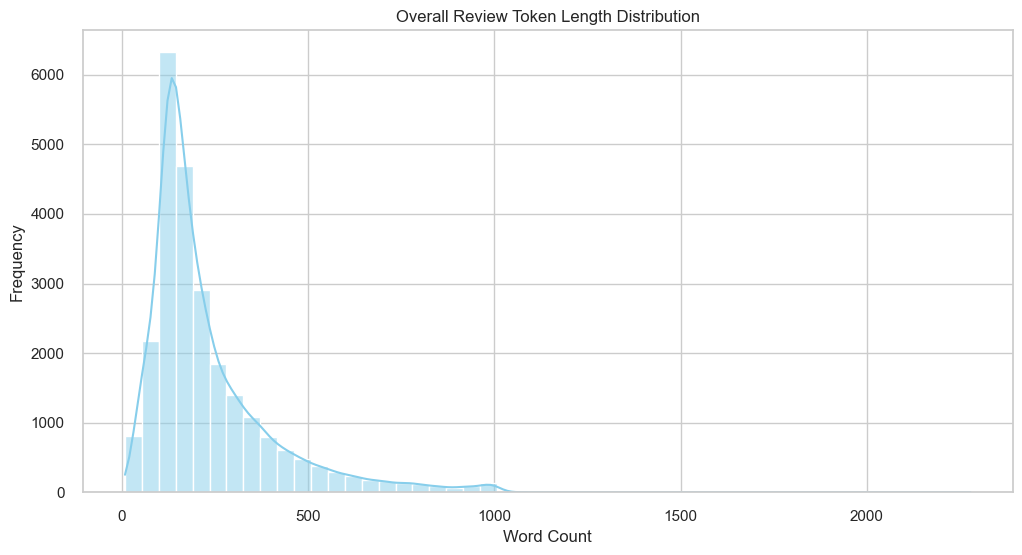

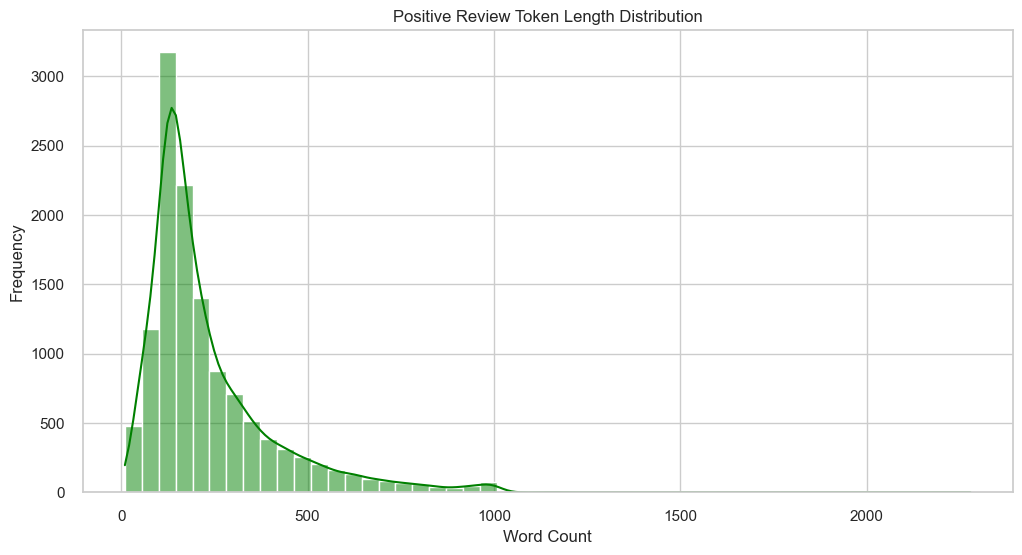

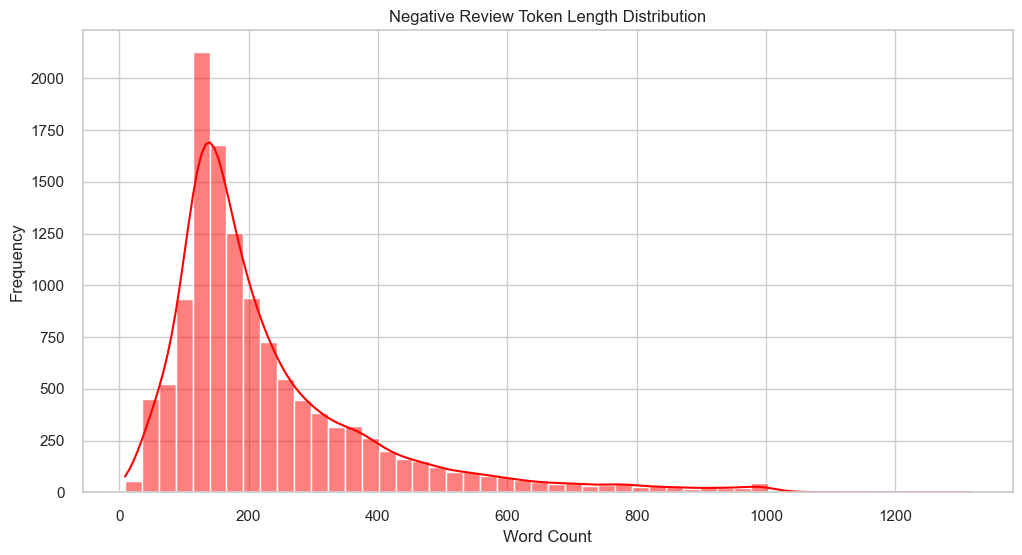

In [35]:
# Load dataset
imdb_data = pd.read_csv('./IMDB Dataset.csv/IMDB Dataset.csv')

# Take only 50% of the dataset
imdb_data = imdb_data.sample(frac=0.5, random_state=42)

# Create a binary label column
imdb_data['label'] = (imdb_data['sentiment'] == 'positive').astype(int)

# Check balance of dataset
print(imdb_data['sentiment'].value_counts())

# Check word count of each review
imdb_data['word_count'] = imdb_data['review'].apply(lambda x: len(x.split()))

# Set styling as seaborn for convenience
sns.set(style='whitegrid')

# Plot word count distributions
plt.figure(figsize=(12, 6))

# Overall review word count distribution
sns.histplot(imdb_data['word_count'], bins=50, kde=True, color='skyblue')
plt.title('Overall Review Token Length Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Positive review word count distribution
plt.figure(figsize=(12, 6))
sns.histplot(imdb_data[imdb_data['label'] == 1]['word_count'], bins=50, kde=True, color='green')
plt.title('Positive Review Token Length Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

# Negative review word count distribution
plt.figure(figsize=(12, 6))
sns.histplot(imdb_data[imdb_data['label'] == 0]['word_count'], bins=50, kde=True, color='red')
plt.title('Negative Review Token Length Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

Pobieramy dane, gdy nie mamy ich jeszcze w katalogu roboczym (korzystam tutaj z danych wystawionych przez kaggle, gdyż nie udało mi się pobrać całego zbioru przy pomocy biblioteki pytorch mimo wielu prób). Następnie wczytujemy dane do dataframe'u i wyświetlamy pierwsze 5 wierszy i ostatnie 5 wierszy. Potem dodajemy kolumnę wyrażającą liczbowo czy opinia jest pozytywna (1) czy negatywna (0). Następnie wyświetlamy statystki dotyczące liczby tokenów w poszczególnych opiniach, które są po prostu ciągami znaków odzielonych spacjami. Widzimy, że średnio opinie mają około 230 tokenów, a mediana to 173. Na koniec wyświetlamy wykresy rozkładu liczby tokenów w opiniach dla pozytywnych i negatywnych opinii. Widzimy, że negatywne opinie są nieco krótsze niż pozytywne.

## 3. Czyszczenie i przygotowanie danych.

100%|██████████| 25000/25000 [01:16<00:00, 325.99it/s]


<Figure size 1000x600 with 0 Axes>

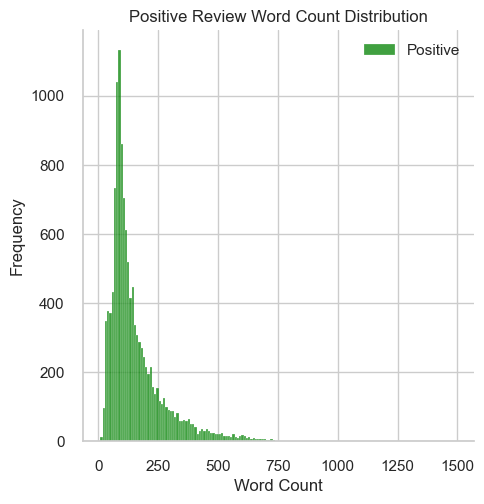

<Figure size 1000x600 with 0 Axes>

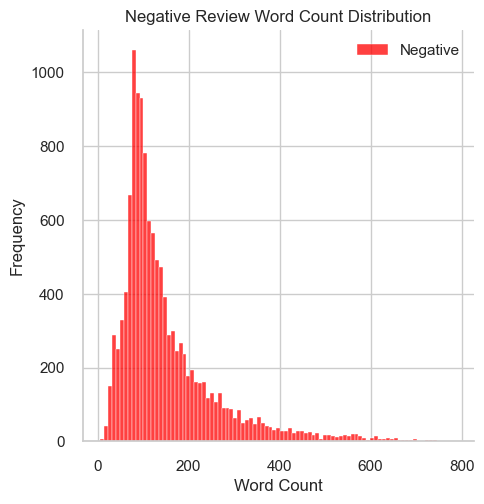

In [43]:
# text cleaning

def clean_text(text):
    # Remove links and HTML tags
    text = re.sub(r'https?://\S+|www\.\S+|<[^>]+>', '', text)
    
    # Remove non-ASCII characters, emojis, and extra whitespaces
    text = re.sub(r'[^\x00-\x7f]|['
                  u'\U0001F600-\U0001F64F'
                  u'\U0001F300-\U0001F5FF'
                  u'\U0001F680-\U0001F6FF'
                  u'\U0001F1E0-\U0001F1FF'
                  u'\U00002702-\U000027B0'
                  u'\U000024C2-\U0001F251'
                  ']+', '', text)
    
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces
    
    # Correct repeated characters (e.g., loooove -> love)
    text = re.sub(r'(.)\1+', r'\1\1', text)
    
    return text

def preprocess_text(text):
    # Tokenize and remove stopwords
    tokens = [word for word in word_tokenize(text) if word.lower() not in stopwords]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(lemmas)

# Assuming you have 'imdb_data' DataFrame with a 'review' column
imdb_data['cleaned'] = imdb_data['review'].progress_apply(clean_text)
imdb_data['processed'] = imdb_data['cleaned'].progress_apply(preprocess_text)

# Keep only the 'processed' and 'label' columns
imdb_data[['processed', 'label']].to_csv('./imdb_processed.csv', index=False, header=True)

plt.figure(figsize=(10, 6))
sns.displot(imdb_data[imdb_data['label'] == 1]['processed'].apply(lambda x: len(x.split())), kde=False, color='green', label='Positive')
plt.title('Positive Review Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot the word count distribution for negative reviews
plt.figure(figsize=(10, 6))
sns.displot(imdb_data[imdb_data['label'] == 0]['processed'].apply(lambda x: len(x.split())), kde=False, color='red', label='Negative')
plt.title('Negative Review Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

W tym etapie przygotowujemy dane oczyszczając je poprzez usunięcie z nich niepotrebnych elementów które działałyby jako szum dla modelu:
- usuwamy znaki interpunkcyjne sklejające 2 tokeny (np. "Shut up!Okey" -> "Shut up Okey"),
- usuwamy liczby,
- usuwamy różnego rodzaju emoji i znaki non-ascii,
- usuwamy linki,
- usuwamy html,
- dodajemy spacje pomiędzy znakami interpunkcyjnymi.

Następnie przy użyciu biblioteki do przetwarzania języka naturalnego nltk usuwamy stopwords nie należące do tych z biblioteki (słowa które nie niosą żadnej informacji o treści tekstu) oraz stemujemy słowa (sprowadzamy je do ich podstawowej formy). Na koniec wyświetlamy pierwsze 5 wierszy i ostatnie 5 wierszy po oczyszczeniu danych.

Wynik zapisujemy do innej CSVki, aby nie musieć za każdym razem oczyszczać danych.

## 4. Przygotowanie danych do modelu.

In [44]:
# Load processed data
data = pd.read_csv('./imdb_processed.csv')

# Display the first two processed reviews and their labels
for _, row in data.head(2).iterrows():
    print(row['processed'])
    print(f'Label: {row["label"]}\n')

# Get all processed reviews
reviews = data.processed.values

# Merge into a single variable, separated by whitespaces
words = ' '.join(reviews)

# Obtain a list of words
words = words.split()

# Check the first 10 words in the list
print(words[:10])

# Build vocabulary
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'
word2int = {word: id for id, word in int2word.items()}

# Encode words
reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

# Print the first 5 words of the first 5 reviews
for i in range(5):
    print(reviews_enc[i][:5])

# Padding sequences
def pad_features(reviews, pad_id, seq_length):
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)

    for i, row in enumerate(reviews):
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

# Set sequence lengths to 100 and 200
seq_length_100 = 100
seq_length_200 = 200

# Pad features for both sequence lengths
features_100 = pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length_100)
features_200 = pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length_200)

# Assert the lengths of the features
assert len(features_100) == len(reviews_enc)
assert len(features_100[0]) == seq_length_100

assert len(features_200) == len(reviews_enc)
assert len(features_200[0]) == seq_length_200

# Display the first 10x10 elements of the features
print(features_100[:10, :10])
print(features_200[:10, :10])

# Get labels as numpy
labels = data.label.to_numpy()


really liked Summerslam due look arena , curtain look overall interesting reason . Anyways , could one best Summerslam 's ever WWF n't Lex Luger main event Yokozuna , 's time ok huge fat man v strong man 'm glad time changed . terrible main event like every match Luger terrible . match card Razor Ramon v Ted Dibiase , Steiner Brothers v Heavenly Bodies , Shawn Michaels v Curt Hening , event Shawn named big monster body guard Diesel , IRS v 1-2-3 Kid , Bret Hart first take Doink take Jerry Lawler stuff Harts Lawler always interesting , Ludvig Borga destroyed Marty Jannetty , Undertaker took Giant Gonzalez another terrible match , Smoking Gunns Tatanka took Bam Bam Bigelow Headshrinkers , Yokozuna defended world title Lex Luger match boring terrible ending . However deserves 8/10
Label: 1

many television show appeal quite many different kind fan like Farscape .. know youngster 30/40+ year old ; fan Male Female many different country think adore T.V miniseries . element found almost ever

100%|██████████| 25000/25000 [00:01<00:00, 15524.17it/s]


[24, 328, 32122, 551, 57]
[51, 556, 35, 1009, 102]
[5, 734, 20, 578, 963]
[960, 2831, 19, 356, 12594]
[23769, 503, 267, 308, 22]
[[   24   328 32122   551    57 14002     1  6922    57   639]
 [   51   556    35  1009   102    51   187   141   119    13]
 [    5   734    20   578   963    26    62  7786  3360     2]
 [  960  2831    19   356 12594    11    12  7788  5487  1154]
 [23769   503   267   308    22     4     1   103  1192  4968]
 [   67   192     4   814  1587  2738    43     1    56    20]
 [   21   292  9799  1299   459  1569   241     2 32127 11521]
 [ 1551     1     9    20 15830    38    40    15   192   184]
 [  550   138     2    78   510  1223     3     2   423   652]
 [   40   857   105 19510  2306 37038  2768     1 19511   296]]
[[   24   328 32122   551    57 14002     1  6922    57   639]
 [   51   556    35  1009   102    51   187   141   119    13]
 [    5   734    20   578   963    26    62  7786  3360     2]
 [  960  2831    19   356 12594    11    12  7788  

Na tym etapie musimy z przekształconych danych utworzyć słownik, który będzie mapował słowa na liczby. Dzięki temu będziemy mogli przekształcać słowa na wektory z użyciem one-hot encoding. Dodatkowo, musimy przyciąć i dopełnić opinie do ustalonej długości, aby móc przeprowadzać uczenie w paczkach. Opinie, które nie mają dostatecznej długości padujemy tokenem '\<PAD>'. Obcinamy do 2 wielkości, aby mieć porównanie jak wpływa to na wyniki. Następnie wyśwwietlamy kody pierwszych 5 słów z pierwszych 5 wierszy.

## 5. Podział danych i przygotwanie dataloaderów.

In [50]:
# Define sequence lengths
seq_lengths = [100, 200]

test_size = 0.2 
# Pad features for each sequence length
features = [pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length) for seq_length in seq_lengths]

# Split data into train, validation, and test sets for each sequence length
train_test_splits = [train_test_split(feature, labels, test_size=test_size, random_state=2) for feature in features]

# Display the shape of the datasets
print('Feature Shapes:')
print('===============')
for seq_length, (X_train, X_test, Y_train, Y_test) in zip(seq_lengths, train_test_splits):
    print(f'Train set ({seq_length}): {X_train.shape}')
    print(f'Test set ({seq_length}): {X_test.shape}')

# Define batch size
batch_size = 400

# Create tensor datasets and dataloaders for each sequence length
trainsets = [TensorDataset(torch.from_numpy(X_train), torch.from_numpy(Y_train)) for X_train, _, Y_train, _ in train_test_splits]
testsets = [TensorDataset(torch.from_numpy(X_test), torch.from_numpy(Y_test)) for _, X_test, _, Y_test in train_test_splits]

train_loaders = [DataLoader(trainset, shuffle=True, batch_size=batch_size) for trainset in trainsets]
test_loaders = [DataLoader(testset, shuffle=False, batch_size=batch_size) for testset in testsets]



Feature Shapes:
Train set (100): (20000, 100)
Test set (100): (5000, 100)
Train set (200): (20000, 200)
Test set (200): (5000, 200)


Na tym etapie dzielimy dane na zbiór treningowy i testowy w proporcjach 80:20. Robimy tak dla zestawu przyciętego i spadowanego do 200 znaków i do 150 znaków.

## 6. Budowa modeli.

In [59]:
class SentimentLSTMModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size, embedding_size, n_layers):
        super(SentimentLSTMModel, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        # embedding layer is useful to map input into vector representation
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # LSTM layer preserved by PyTorch library
        self.lstm = nn.LSTM(embedding_size, hidden_size, n_layers, batch_first=True)

        # Linear layer for output
        self.fc = nn.Linear(hidden_size, output_size)

        # Sigmoid layer cz we will have binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):

        # convert feature to long
        x = x.long()

        # map input to vector
        x = self.embedding(x)

        # pass forward to lstm
        o, hidden =  self.lstm(x, hidden)

        # get last sequence output
        o = o[:, -1, :]

        # apply fully connected layer
        o = self.fc(o)

        # sigmoid
        o = self.sigmoid(o)

        return o, hidden

    def initHidden(self, batch_size):
        # initialize hidden state
        # (num_layers, batch_size, hidden_size)
        return torch.zeros(self.n_layers, batch_size, self.hidden_size), torch.zeros(self.n_layers, batch_size, self.hidden_size)



class SentimentRNNModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size, embedding_size, n_layers):
        super(SentimentRNNModel, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        # embedding layer is useful to map input into vector representation
        self.embedding = nn.Embedding(vocab_size, embedding_size)

        # RNN layer preserved by PyTorch library
        self.rnn = nn.RNN(embedding_size, hidden_size, n_layers, batch_first=True)

        # Linear layer for output
        self.fc = nn.Linear(hidden_size, output_size)

        # Sigmoid layer cz we will have binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        # convert feature to long
        x = x.long()

        # map input to vector
        x = self.embedding(x)

        # pass forward to lstm
        o, hidden =  self.rnn(x, hidden)

        # get last sequence output
        o = o[:, -1, :]

        # apply fully connected layer
        o = self.fc(o)

        # sigmoid
        o = self.sigmoid(o)

        return o, hidden

    def initHidden(self, batch_size):
        # initialize hidden state
        # (num_layers, batch_size, hidden_size)
        return torch.zeros(self.n_layers, batch_size, self.hidden_size)

In [67]:
class SentimentBaseModel(nn.Module):
    def __init__(self, vocab_size, output_size, hidden_size, embedding_size, n_layers, rnn_type):
        super(SentimentBaseModel, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        # Create RNN layer based on the specified type
        rnn_types = {'LSTM': nn.LSTM, 'RNN': nn.RNN}
        if rnn_type not in rnn_types:
            raise ValueError("Invalid RNN type. Supported types: 'LSTM' or 'RNN'.")
        self.rnn = rnn_types[rnn_type](embedding_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        x = x.long()
        x = self.embedding(x)
        o, hidden = self.rnn(x, hidden)
        o = o[:, -1, :]
        o = self.fc(o)
        o = self.sigmoid(o)

        return o, hidden

    def initHidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size), torch.zeros(self.n_layers, batch_size, self.hidden_size)

class SentimentLSTMModel(SentimentBaseModel):
    def __init__(self, vocab_size, output_size, hidden_size, embedding_size, n_layers):
        super(SentimentLSTMModel, self).__init__(vocab_size, output_size, hidden_size, embedding_size, n_layers, 'LSTM')

    def initHidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size), torch.zeros(self.n_layers, batch_size, self.hidden_size)

class SentimentRNNModel(SentimentBaseModel):
    def __init__(self, vocab_size, output_size, hidden_size, embedding_size, n_layers):
        super(SentimentRNNModel, self).__init__(vocab_size, output_size, hidden_size, embedding_size, n_layers, 'RNN')
    
    def initHidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size)

W tym etapie definiujemy 2 różne modele, które różnią się tak naprawdę rodzajem warstwy rekurencyjnej - pierwszy korzysta z LSTM, natomiast drugi z RNN. Do klasyfikacji używamy warstwy Linear z funkcją sigmoidalną.

## 7. Trenowanie modeli.

In [68]:
hidden_sizes = [32, 16]

# define hyperparameters
vocab_size = len(word2int)
output_size = 1
embedding_sizes = [100, 200]
n_layers = 2
epochs = 1

# define loss function
loss_fn = nn.BCELoss()

models_with_optims = []
for hidden_size in hidden_sizes:
    for embedding_size in embedding_sizes:
        model = SentimentLSTMModel(vocab_size, output_size, hidden_size, embedding_size, n_layers)
        model2 = SentimentRNNModel(vocab_size, output_size, hidden_size, embedding_size, n_layers)

        optimizer = Adam(model.parameters())
        optimizer2 = Adam(model2.parameters())

        models_with_optims.append((model, optimizer, f'LSTM (hidden_size={hidden_size}, embedding_size={embedding_size})'))
        models_with_optims.append((model2, optimizer2, f'RNN (hidden_size={hidden_size}, embedding_size={embedding_size})'))


losses_over_epochs = defaultdict(list)

def train(model, optimizer, information_str, trainloader, testloader, epochs):
    print(information_str)
    model.train()
    for epoch in range(epochs):
        for (inputs, labels) in trainloader:
            optimizer.zero_grad()
            batch_size = inputs.size(0) 
            hidden = model.initHidden(batch_size)
            output, hidden = model(inputs, hidden)
            loss = loss_fn(output.squeeze(), labels.float())
            loss.backward()
            optimizer.step()
            losses_over_epochs[information_str].append(loss.item())
        print(f"Epoch: {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        y_pred = []
        y_true = []
        for (inputs, labels) in testloader:
            batch_size = inputs.size(0) 
            hidden = model.initHidden(batch_size)
            output, hidden = model(inputs, hidden)
            y_pred.extend(output.squeeze().tolist())
            y_true.extend(labels.tolist())
        report = classification_report(y_true, np.array(y_pred) > 0.5, target_names=['Negative', 'Positive'])
        print(f'\nClassification Report:\n{report}')

    print('-' * 100)
    return model

for index, (model, optimizer, information_str) in enumerate(models_with_optims):
    training_loader = train_loaders[(index % 4) // 2]
    test_loader = test_loaders[(index % 4) // 2]
    train(model, optimizer, information_str, training_loader, test_loader, epochs)

LSTM (hidden_size=32, embedding_size=100)
Epoch: 1/1, Loss: 0.6895

Classification Report:
              precision    recall  f1-score   support

    Negative       0.51      0.90      0.66      2553
    Positive       0.52      0.11      0.18      2447

    accuracy                           0.51      5000
   macro avg       0.52      0.51      0.42      5000
weighted avg       0.52      0.51      0.42      5000

----------------------------------------------------------------------------------------------------
RNN (hidden_size=32, embedding_size=100)
Epoch: 1/1, Loss: 0.6934

Classification Report:
              precision    recall  f1-score   support

    Negative       0.52      0.34      0.41      2553
    Positive       0.50      0.68      0.57      2447

    accuracy                           0.51      5000
   macro avg       0.51      0.51      0.49      5000
weighted avg       0.51      0.51      0.49      5000

----------------------------------------------------------------

KeyboardInterrupt: 

Na tym etapie definiujemy parametry dla których będziemy trenować modele. Każdy z modeli trenujemy dla każdego zestawu tych parametrów:
- wielkość ukrytej warstwy rekurencyjnej - 32, 64,
- wielkość warstwy embedding - 150, 200.

Następnie dla każdego modelu zapamiętujemy funkcje kosztu w czasie uczenia i wyświetlamy koszt w kolejnych epokach. Jako funkcję kosztu używamy Binary Cross Entropy Loss (BCELoss). Na koniec procesu uczenia każdego modelu wyświetlamy statystyki określające jak dobrze model klasyfikuje dane testowe. Z dziwnego powodu model z warstwą RNN bardzo późno zaczyna się uczyć i osiąga bardzo słabe wyniki. Model z warstwą LSTM osiąga dużo lepsze wyniki. Najlepszy wynik to dokładność na poziomie 85% na zbiorze testowym dla wielkości wartswy rekurenycjnej 64 i wielkości warstwy embedding 150.

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

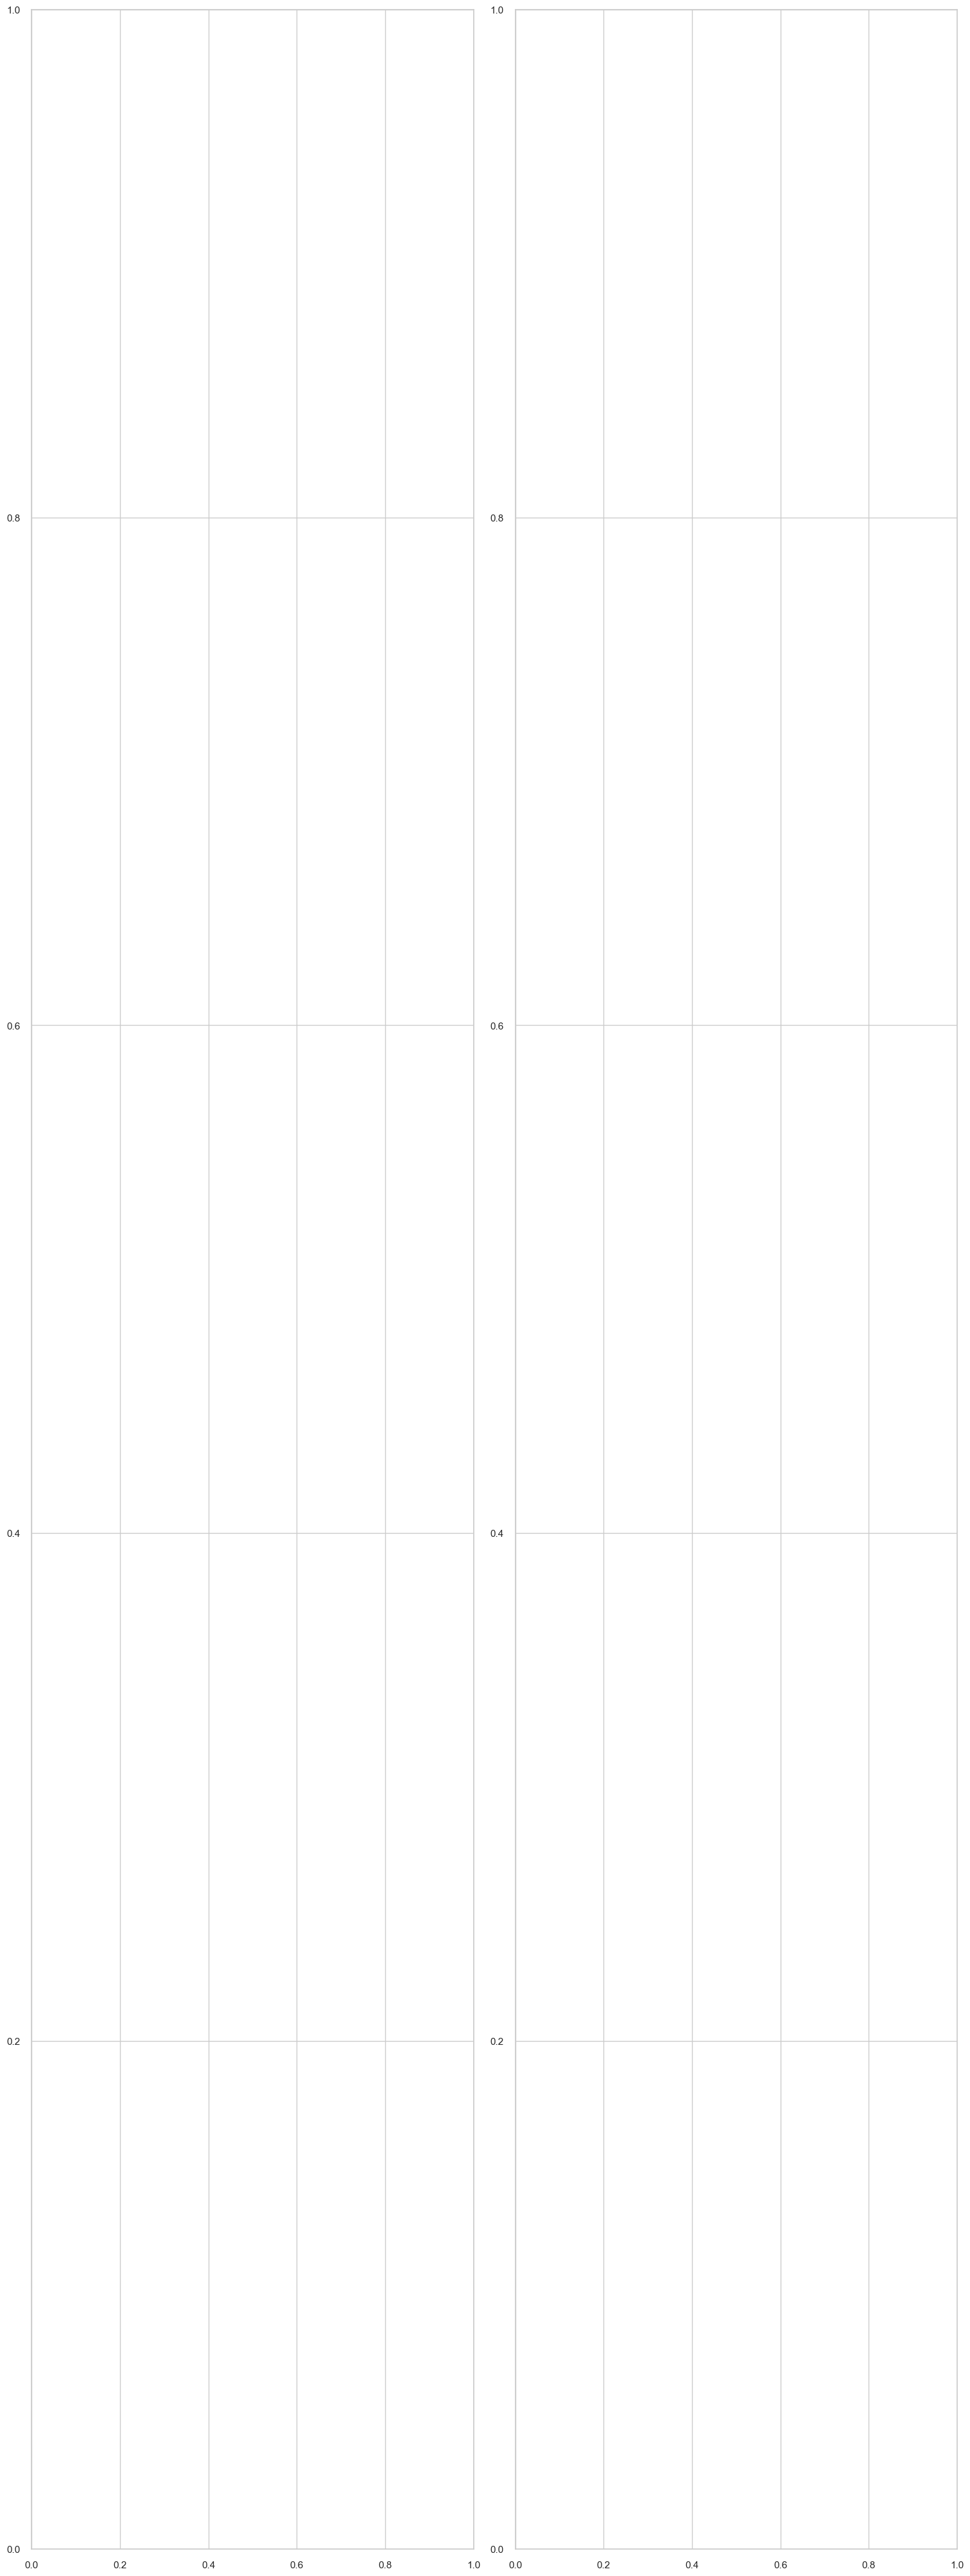

In [63]:
# fig, axs = plt.subplots(len(losses_over_epochs) // 2, 2, figsize=(15, 40), layout='constrained')
# for index, (name, data) in enumerate(losses_over_epochs.items()):
#     axs[index // 2, index % 2].plot(data)
#     axs[index // 2, index % 2].plot(np.convolve(data, np.ones(20) / 20, mode='valid'))
#     axs[index // 2, index % 2].set_title(name)
#     axs[index // 2, index % 2].set_ylim([0.6, 0.8])  # Set y-axis limit

# for ax in axs.flat:
#     ax.set(xlabel='Epoch', ylabel='Loss')

# plt.show()

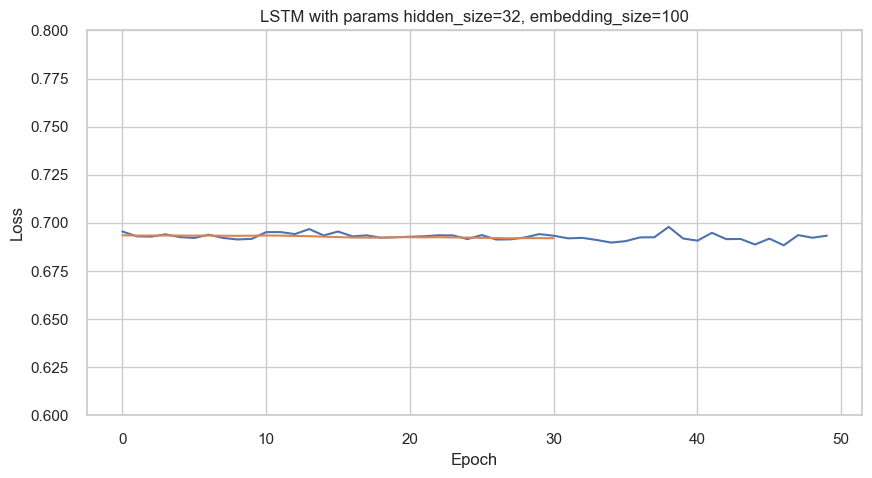

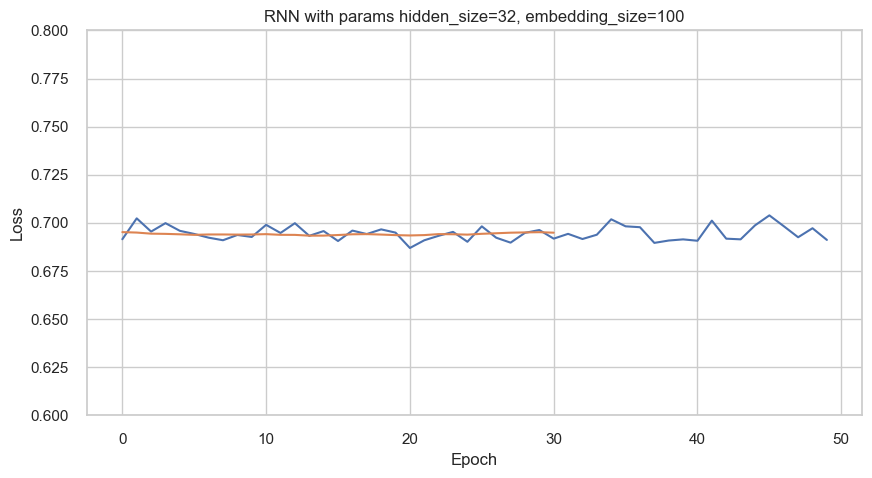

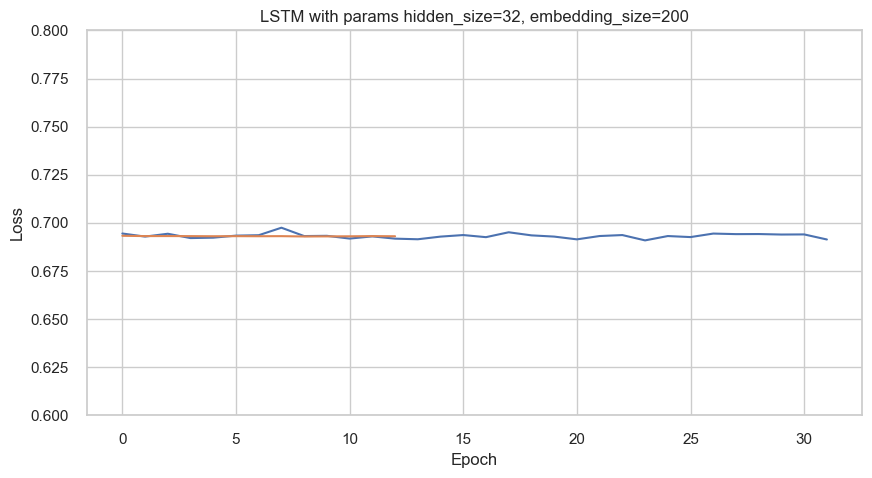

In [64]:

for name, data in losses_over_epochs.items():
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(data)
    ax.plot(np.convolve(data, np.ones(20) / 20, mode='valid'))
    ax.set_title(name)
    ax.set_ylim([0.6, 0.8])  # Set y-axis limit
    ax.set(xlabel='Epoch', ylabel='Loss')
    plt.show()


Na koniec wyświetlamy wykresy funkcji kosztu w czasie uczenia dla każdego modelu. Możemy zauważyć charakterystyczne dla modeli rekurencyjnych "skoki" w funkcji kosztu. Nagłe wzniesienia możemy wyjaśnić poprzez użycie przez optymalizator momentum, który przyspiesza uczenie, ale może powodować takie skoki w przypadku gdy optymalizator "przeskoczy" minimum lokalne. Możemy też zauważyć, że model z warstwą LSTM dla zadanych hiperparametrów osiąga niższy poziom funkcji kosztu niż model z warstwą RNN.

10%
